# Random Forest

In [37]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction import FeatureHasher
# from sklearn.model_selection import train_test_split
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)                    

In [4]:
path = os.getcwd()
path = path.replace("\\", "\\\\")
path = path.replace("\\\\", "/")
path_data = "/".join(path.split("/")[:-1]) + "/Data/"
path_est = path_data + "Estandarizada/"

In [6]:
df = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df['FECHA'] = pd.to_datetime(df.FECHA).dt.to_period('m')

In [7]:
df

,FECHA,PROVINCIA,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA
0,2020-01,A CORUÑA,58.0,11.519355,3.848387,23.580645,3.706452,12.183871,1013.903226,3.838710,0.09
1,2020-01,ALBACETE,674.0,6.996774,1.354839,32.483871,0.916129,6.451613,945.961290,5.474194,0.00
2,2020-01,ALICANTE,81.0,11.664516,1.193548,22.000000,1.767742,7.741935,1013.180645,6.896774,0.00
3,2020-01,ALMERIA,21.0,12.487097,0.690323,53.967742,3.425806,9.629032,1020.690323,6.409677,0.00
4,2020-01,ARABA/ALAVA,513.0,5.445161,0.948387,54.516129,3.229032,10.045161,963.483871,3.254839,0.00
...,...,...,...,...,...,...,...,...,...,...,...
1971,2023-02,TOLEDO,690.0,5.757143,0.028571,19.892857,3.935714,11.978571,940.478571,7.700000,40.03
1972,2023-02,VALENCIA,56.0,9.582143,1.014286,59.678571,2.817857,8.164286,1015.625000,6.250000,24.16
1973,2023-02,VALLADOLID,846.0,4.242857,0.267857,13.107143,3.760714,9.750000,924.460714,7.260714,78.59
1974,2023-02,ZAMORA,715.0,5.128571,0.335714,20.071429,1.757143,8.932143,939.407143,6.792857,183.92


In [8]:
#Crear un objeto FeatureHasher
fh = FeatureHasher(n_features=5, input_type='string')

#Transformar la variable categórica utilizando la codificación Hashing
hashed = fh.transform(df['PROVINCIA'])

#Convertir el resultado en un dataframe
hashed_df = pd.DataFrame(hashed.toarray())

#Unir el dataframe original con el dataframe de características codificadas
df = pd.concat([df, hashed_df], axis=1)
df = df.drop(columns=['PROVINCIA'])

In [9]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3)
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_train = df_train.drop(columns=["index"])
df_test = df_test.drop(columns=["index"])

In [91]:
#df_train = df[(df['FECHA'] >= '2020-01-01 00:00:00') & (df['FECHA'] <= '2021-11-30 23:59:59')]
#df_test  = df[(df['FECHA'] >= '2021-12-01 00:00:00')]

In [10]:
df_train = df_train.set_index('FECHA')
df_test = df_test.set_index('FECHA')

In [11]:
df_train.reset_index(drop = True, inplace = True)

2
4
8
16
32
64
128
256


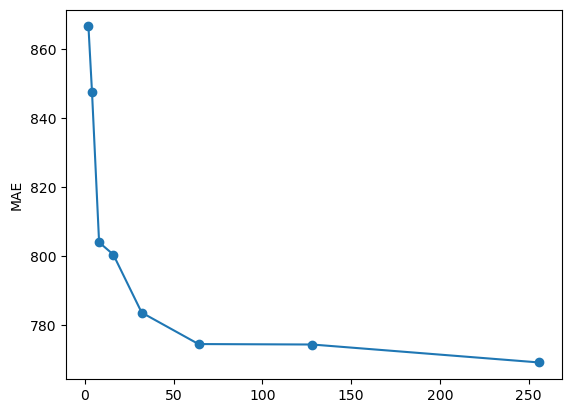

In [14]:
cv = TimeSeriesSplit()
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256] #, 512, 1024]

total_scores = []
for estimators in l_estimators:
    print(estimators)
    fold_accuracy = []
    regressor =  RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)
    for train_fold, test_fold in cv.split(df_train):
        #División train test aleatoria
        f_train = df_train.loc[train_fold]
        f_test = df_train.loc[test_fold]
        # entrenamiento y ejecución del modelo
        regressor.fit(X = f_train.drop(['TASA_INCIDENCIA'], axis=1), y = f_train['TASA_INCIDENCIA'])
        y_pred = regressor.predict(X = f_test.drop(['TASA_INCIDENCIA'], axis = 1))
        # evaluación del modelo
        mae = mean_absolute_error(f_test['TASA_INCIDENCIA'], y_pred)
        fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 

In [15]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 256, MAE = 769.23)


In [16]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', 
                                   random_state=0)
# fit and predict

regressor.fit( X = df_train.drop(['TASA_INCIDENCIA'], axis=1), y = df_train['TASA_INCIDENCIA'])
y_pred = regressor.predict(X = df_test.drop(['TASA_INCIDENCIA'], axis = 1))

In [17]:
mae = mean_absolute_error(df_test['TASA_INCIDENCIA'], y_pred)
print ('MAE', mae)

MAE 725.3149979579468


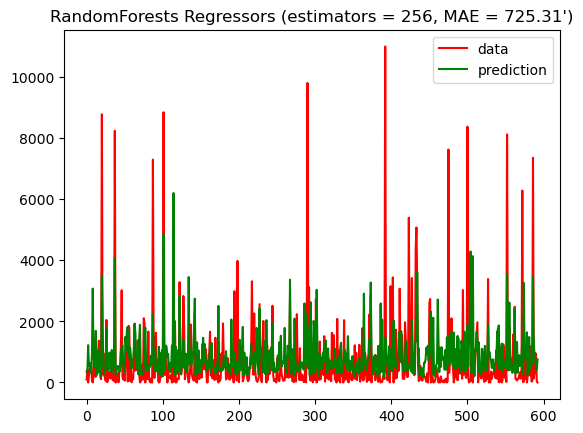

In [18]:
xx = np.stack(i for i in range(df_test['TASA_INCIDENCIA'].shape[0]))
plt.plot(xx, df_test['TASA_INCIDENCIA'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [19]:
regressor.feature_importances_

array([0.03645414, 0.17504949, 0.1355737 , 0.10251997, 0.08974392,
       0.11602539, 0.13337605, 0.10916471, 0.01819262, 0.03221203,
       0.02159293, 0.01007518, 0.02001988])

In [20]:
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('ALTITUD', 'TEMP_MED', 'PREC', 'DIR', 'VEL_MEDIA', 'RACHA', 'PRES_MIN', 'SOL', 
                             '0', '1', '2', '3', '4') 
              ,'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,ALTITUD,0.036454
1,TEMP_MED,0.175049
2,PREC,0.135574
3,DIR,0.102520
4,VEL_MEDIA,0.089744
5,RACHA,0.116025
6,PRES_MIN,0.133376
7,SOL,0.109165
8,0,0.018193
9,1,0.032212


# Mediante el Método de one hot encoding

In [22]:
df_2 = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df_2['FECHA'] = pd.to_datetime(df_2.FECHA).dt.to_period('m')

In [23]:
df_2

,FECHA,PROVINCIA,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA
0,2020-01,A CORUÑA,58.0,11.519355,3.848387,23.580645,3.706452,12.183871,1013.903226,3.838710,0.09
1,2020-01,ALBACETE,674.0,6.996774,1.354839,32.483871,0.916129,6.451613,945.961290,5.474194,0.00
2,2020-01,ALICANTE,81.0,11.664516,1.193548,22.000000,1.767742,7.741935,1013.180645,6.896774,0.00
3,2020-01,ALMERIA,21.0,12.487097,0.690323,53.967742,3.425806,9.629032,1020.690323,6.409677,0.00
4,2020-01,ARABA/ALAVA,513.0,5.445161,0.948387,54.516129,3.229032,10.045161,963.483871,3.254839,0.00
...,...,...,...,...,...,...,...,...,...,...,...
1971,2023-02,TOLEDO,690.0,5.757143,0.028571,19.892857,3.935714,11.978571,940.478571,7.700000,40.03
1972,2023-02,VALENCIA,56.0,9.582143,1.014286,59.678571,2.817857,8.164286,1015.625000,6.250000,24.16
1973,2023-02,VALLADOLID,846.0,4.242857,0.267857,13.107143,3.760714,9.750000,924.460714,7.260714,78.59
1974,2023-02,ZAMORA,715.0,5.128571,0.335714,20.071429,1.757143,8.932143,939.407143,6.792857,183.92


In [25]:
oe_style = OneHotEncoder()

oe_results = oe_style.fit_transform(df_2[["PROVINCIA"]]) 
df_2 = df_2.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

df_2 = df_2.drop(columns=['PROVINCIA'])

In [26]:
df_train_2, df_test_2 = train_test_split(df_2, test_size=0.3)
df_train_2 = df_train_2.reset_index()
df_test_2 = df_test_2.reset_index()
df_train_2 = df_train_2.drop(columns=["index"])
df_test_2 = df_test_2.drop(columns=["index"])

In [27]:
df_train_2 = df_train_2.set_index('FECHA')
df_test_2 = df_test_2.set_index('FECHA')
df_train_2.reset_index(drop = True, inplace = True)
cv = TimeSeriesSplit()

2
4
8
16
32
64
128
256


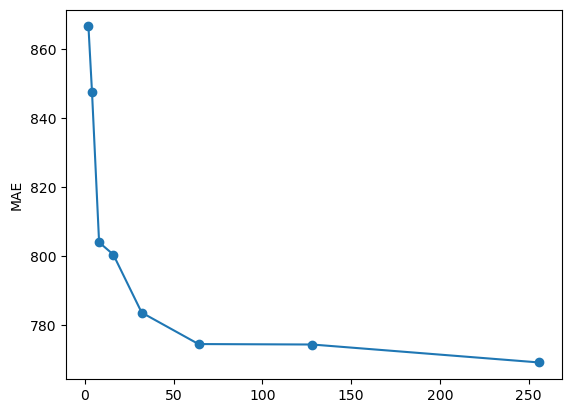

In [29]:
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256] #, 512, 1024]

total_scores = []
for estimators in l_estimators:
    print(estimators)
    fold_accuracy = []
    regressor =  RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)
    for train_fold, test_fold in cv.split(df_train_2):
        #División train test aleatoria
        f_train = df_train.loc[train_fold]
        f_test = df_train.loc[test_fold]
        # entrenamiento y ejecución del modelo
        regressor.fit(X = f_train.drop(['TASA_INCIDENCIA'], axis=1), y = f_train['TASA_INCIDENCIA'])
        y_pred = regressor.predict(X = f_test.drop(['TASA_INCIDENCIA'], axis = 1))
        # evaluación del modelo
        mae = mean_absolute_error(f_test['TASA_INCIDENCIA'], y_pred)
        fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show()

In [30]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 256, MAE = 769.23)


In [33]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', 
                                   random_state=0)
# fit and predict

regressor.fit( X = df_train_2.drop(['TASA_INCIDENCIA'], axis=1), y = df_train_2['TASA_INCIDENCIA'])
y_pred = regressor.predict(X = df_test_2.drop(['TASA_INCIDENCIA'], axis = 1))

In [34]:
mae = mean_absolute_error(df_test['TASA_INCIDENCIA'], y_pred)
print ('MAE', mae)

MAE 852.9633602642812


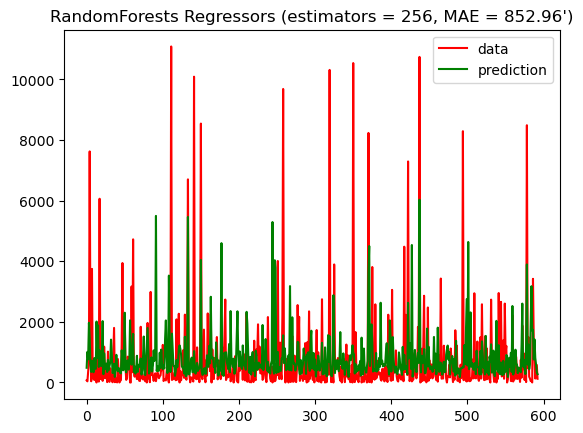

In [35]:
xx = np.stack(i for i in range(df_test_2['TASA_INCIDENCIA'].shape[0]))
plt.plot(xx, df_test_2['TASA_INCIDENCIA'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()